<a href="https://colab.research.google.com/github/salarMokhtariL/Cat-vs.-Dog-Image-Classification-using-CNN/blob/main/cat_dog_cnn_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle
from google.colab import files
import os

!kaggle datasets download -d mahmudulhaqueshawon/catcat
!unzip catcat.zip -d /content/catcat

Dataset URL: https://www.kaggle.com/datasets/mahmudulhaqueshawon/catcat
License(s): apache-2.0
 94% 59.0M/62.9M [00:00<00:00, 81.7MB/s]
100% 62.9M/62.9M [00:00<00:00, 76.4MB/s]
Archive:  catcat.zip
  inflating: /content/catcat/test/cat_s/cat_1.jpg  
  inflating: /content/catcat/test/cat_s/cat_106.jpg  
  inflating: /content/catcat/test/cat_s/cat_109.jpg  
  inflating: /content/catcat/test/cat_s/cat_113.jpg  
  inflating: /content/catcat/test/cat_s/cat_114.jpg  
  inflating: /content/catcat/test/cat_s/cat_116.jpg  
  inflating: /content/catcat/test/cat_s/cat_118.jpg  
  inflating: /content/catcat/test/cat_s/cat_119.jpg  
  inflating: /content/catcat/test/cat_s/cat_124.jpg  
  inflating: /content/catcat/test/cat_s/cat_140.jpg  
  inflating: /content/catcat/test/cat_s/cat_147.jpg  
  inflating: /content/catcat/test/cat_s/cat_156.jpg  
  inflating: /content/catcat/test/cat_s/cat_158.jpg  
  inflating: /content/catcat/test/cat_s/cat_162.jpg  
  inflating: /content/catcat/test/cat_s/cat_18.j

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import os
from PIL import Image
import numpy as np

In [3]:
train_dir = '/content/train'
test_dir = '/content/test'

In [4]:
class DN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=2, padding=0)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=0)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2, padding=0)
        self.bn3 = nn.BatchNorm2d(32)

        nn.MaxPool2d(2)

        # Calculate output size after convolutions
        def conv2d_size_out(size, kernel_size=5, stride=2):
            return (size - (kernel_size - 1) - 1) // stride + 1

        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32

        # Fully connected layers
        self.head = nn.Linear(linear_input_size, linear_input_size)
        self.head_out = nn.Linear(linear_input_size, outputs)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.head(x)
        return self.head_out(x)

In [5]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [6]:
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

In [7]:
def predict_image(image_path, model):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)

    model.eval()
    with torch.no_grad():
        outputs = model(image)
        _, predicted_class = torch.max(outputs, 1)

    class_names = train_dataset.classes
    predicted_class_name = class_names[predicted_class.item()]
    print(f"Predicted class: {predicted_class_name}")
    return predicted_class_name

In [8]:
def plot_related_graphs(training_losses, validation_accuracies, fold_accuracy, epochs):
    # Plot loss over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(training_losses, label="Training Loss", color='blue')
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

    # Plot accuracy over epochs (for validation)
    plt.figure(figsize=(10, 6))
    plt.plot(validation_accuracies, label="Validation Accuracy", color='green')
    plt.title('Validation Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()

    # Plot the accuracies across the k-folds
    plt.figure(figsize=(10, 6))
    plt.plot(fold_accuracy, marker='o', label="Test Accuracy")
    plt.title('Test Accuracy over Cross Validation Folds')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [9]:
# Cross-validation function
def cross_validation(model, dataset, k_folds=5, batch_size=32, epochs=10):
    kfold = StratifiedKFold(n_splits=k_folds, shuffle=True)
    train_losses = []
    val_accuracies = []
    fold_accuracies = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset.imgs, dataset.targets)):
        print(f"Fold {fold + 1}/{k_folds}")

        train_subsampler = SubsetRandomSampler(train_idx)
        val_subsampler = SubsetRandomSampler(val_idx)

        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler)
        val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_subsampler)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        for epoch in range(epochs):
            model.train()
            running_loss = 0.0
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            train_losses.append(running_loss/len(train_loader))

        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.numpy())
                all_labels.extend(labels.numpy())

        accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(accuracy)

        fold_accuracies.append(accuracy)

    print(f"Average test accuracy: {sum(fold_accuracies)/len(fold_accuracies):.4f}")
    plot_related_graphs(train_losses, val_accuracies, fold_accuracies, epochs)

    return fold_accuracies

In [10]:
input_height = 128
input_width = 128
num_classes = 2

model = DN(input_height, input_width, num_classes)

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Average test accuracy: 0.8396


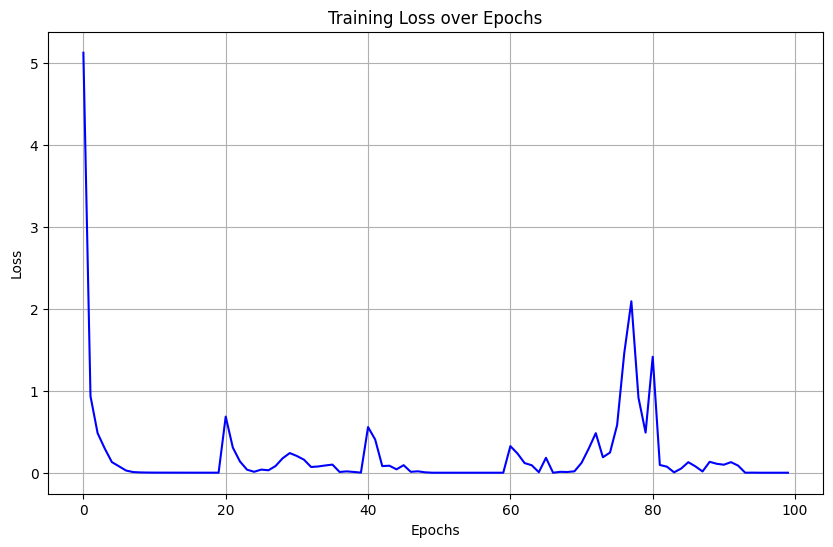

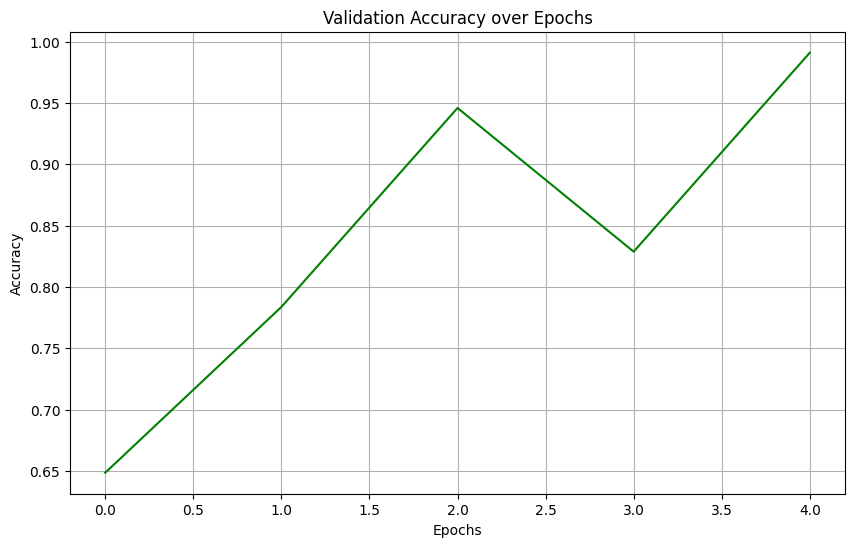

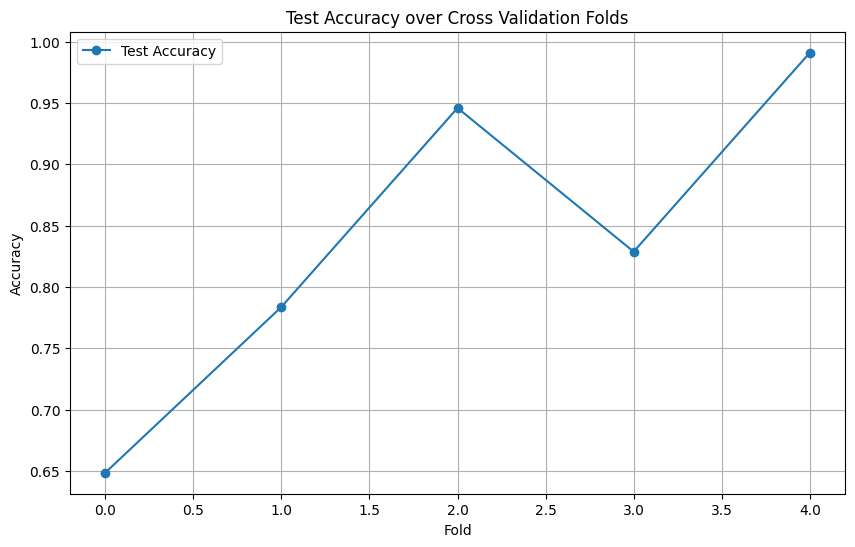

In [12]:
fold_accuracies = cross_validation(model, train_dataset, k_folds=5, batch_size=32, epochs=20)

In [13]:
image_path = '/content/images.jpg'
predicted_class = predict_image(image_path, model)

Predicted class: dogs
